# Classification

## Dowloading MNIST Dataset

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [2]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

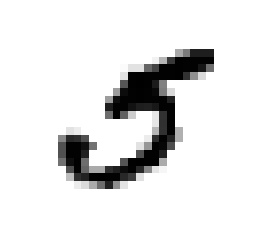

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [5]:
y[36000]

5.0

## Train set & Test set

In [6]:
# This dataset is split in training set (60000) and test set (10000)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Shuffle data
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary Classifier

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [9]:
sgd_clf.predict([some_digit])

array([False], dtype=bool)

## Performance Measures

### Measuring Accuracy using Cross-Validation

In [10]:
# Defining my own cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9277
0.96315
0.93475


In [11]:
# Now using cros_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([ 0.9277 ,  0.96315,  0.93475])

In [12]:
# Demostrating accuracy is not a good scoring measure
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
# Above 90% because 10% of the datasets has 5s,so mosy of the time guess no 5s

array([ 0.90695,  0.9123 ,  0.9097 ])

### Confusion Matrix

In [13]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[51850,  2729],
       [  759,  4662]])

In [15]:
TN,FP,FN,TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1] # True negative, False positive, False negative, True positive

**Precision:** accuracy of the positive predictions

$ precision = \frac{TP}{TP +TF} $

In [16]:
precision = TP/(TP+FP)
precision

0.63076714923555677

**Recall (sensitivity or true positive rate (TPR)):** ratio of positive instances that are correctly detected by the classifier

$recall = \frac{TP}{TP+FN}$

In [17]:
recall = TP/(TP+FN)
recall

0.85998893193137793

**Precision & Recall** from Sci-kit learn

In [20]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) ## Classifier is correct 63% of the time

0.63076714923555677

In [21]:
recall_score(y_train_5, y_train_pred) ## Classifier detects 85% of the 5s

0.85998893193137793

**$F_1$ score**: combine precision & recall, used to compare two classifiers. Use the harmonic mean because a differemce with normal mean, this one gives much more weight to low values. Then, result gets a high $F_1$ score if both precision & recall are high.

$F_1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}} = 2 * \frac{precision*recall}{precision+recall} = \frac{TP}{TP+\frac{FN+Fp}{2}}$

In [22]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7277552294723697

**Precision & recall tradeoff**: increasing precision, reduces recall and vice versa.

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [26]:
from sklearn.metrics import  precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

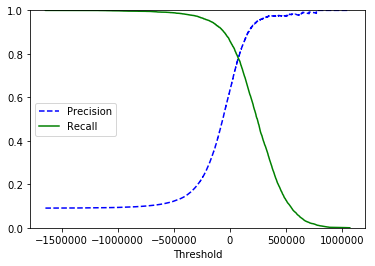

In [34]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)